# Transfer Learning for Hyperparameter Search

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/anl-22-summer-workshop/blob/main/notebooks/4-Transfer-Learning-for-Hyperparameter-Search.ipynb)


In this example we present how to apply transfer-learning for hyperparameter search. Let's assume you have a bunch of similar tasks for example the search of neural networks hyperparameters for different datasets. You can easily imagine that close choices of hyperparameters can perform well these different datasets even if some light additional tuning can help improve the performance. Therefore, you can perform an expensive search once to then reuse the explored set of hyperparameters of thid search and bias the following search with it. Here, we will use a cheap to compute and easy to understand example where we maximise the Ackley function (image bellow). In this case the size of the problem can be defined by the variable $n$. We will start by optimizing the small-size problem where $n=1$, then apply transfer-learning from to optimize the larger-size problem where $n=2$ and visualize the difference if were not to apply transfer-learning on this larger problem instance.

![ackley](https://www.sfu.ca/~ssurjano/ackley.png)

In [1]:
!pip install deephyper sdv

**If running in Google Colab, restart the runtime to load installed packages**. 
* `Runtime > Restart runtime`

In [1]:
import deephyper
print(f"DeepHyper Version: {deephyper.__version__}")


DeepHyper Version: 0.4.1


Let us start by defining the run-functions of the small and large scale problems:

In [2]:
import functools
import numpy as np


def ackley(x, a=20, b=0.2, c=2 * np.pi):
    d = len(x)
    s1 = np.sum(x**2)
    s2 = np.sum(np.cos(c * x))
    term1 = -a * np.exp(-b * np.sqrt(s1 / d))
    term2 = -np.exp(s2 / d)
    y = term1 + term2 + a + np.exp(1)
    return y


def run(config: dict, N: int) -> float:
    x = np.asarray([config[f"x{i}"] ** 2 for i in range(N)])
    y = ackley(x)
    return -y


run_small = functools.partial(run, N=2)
run_large = functools.partial(run, N=5)

Then, we can define the hyperparameter problem space based on $n$

In [3]:
from deephyper.problem import HpProblem


N = 2
problem_small = HpProblem()
for i in range(N):
    problem_small.add_hyperparameter((-10.0, 10.0), f"x{i}")
problem_small

Configuration space object:
  Hyperparameters:
    x0, Type: UniformFloat, Range: [-10.0, 10.0], Default: 0.0
    x1, Type: UniformFloat, Range: [-10.0, 10.0], Default: 0.0

In [4]:
N = 5
problem_large = HpProblem()
for i in range(N):
    problem_large.add_hyperparameter((-10.0, 10.0), f"x{i}")
problem_large

Configuration space object:
  Hyperparameters:
    x0, Type: UniformFloat, Range: [-10.0, 10.0], Default: 0.0
    x1, Type: UniformFloat, Range: [-10.0, 10.0], Default: 0.0
    x2, Type: UniformFloat, Range: [-10.0, 10.0], Default: 0.0
    x3, Type: UniformFloat, Range: [-10.0, 10.0], Default: 0.0
    x4, Type: UniformFloat, Range: [-10.0, 10.0], Default: 0.0

Then, we setup the search and execute it. First we run the search on the small problem.

In [12]:
from deephyper.search.hps import CBO

results = {}
max_evals = 100

search_small = CBO(problem_small, run_small, surrogate_model="GP", random_state=42)
results["Small"] = search_small.search(max_evals)

  0%|          | 0/100 [00:00<?, ?it/s]

Then we perform the search on the large problem **without** transfer-learning.

In [13]:
search_large = CBO(problem_large, run_large, surrogate_model="GP", random_state=42)
results["Large"] = search_large.search(max_evals)

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/romainegele/Documents/Argonne/deephyper/deephyper/skopt/optimizer/optimizer.py:784: UserWarning: The objective has been evaluated at this point before.
  warnings.warn(
/Users/romainegele/Documents/Argonne/deephyper/deephyper/skopt/optimizer/optimizer.py:784: UserWarning: The objective has been evaluated at this point before.
  warnings.warn(
/Users/romainegele/Documents/Argonne/deephyper/deephyper/skopt/optimizer/optimizer.py:784: UserWarning: The objective has been evaluated at this point before.
  warnings.warn(
/Users/romainegele/Documents/Argonne/deephyper/deephyper/skopt/optimizer/optimizer.py:784: UserWarning: The objective has been evaluated at this point before.
  warnings.warn(
/Users/romainegele/Documents/Argonne/deephyper/deephyper/skopt/optimizer/optimizer.py:784: UserWarning: The objective has been evaluated at this point before.
  warnings.warn(
/Users/romainegele/Documents/Argonne/deephyper/deephyper/skopt/optimizer/optimizer.py:784: UserWarning: The objective ha

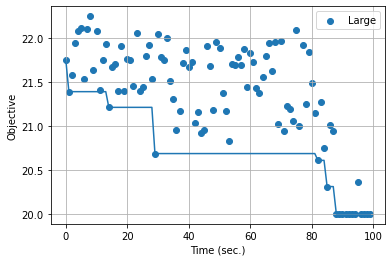

In [17]:
import matplotlib.pyplot as plt


plt.figure()

for strategy, df in results.items():
    if "Large" == strategy:
      x = [i for i in range(len(df))]
      plt.scatter(x, -df.objective, label=strategy)
      plt.plot(x, -df.objective.cummax())

plt.xlabel("Time (sec.)")
plt.ylabel("Objective")
plt.grid()
plt.legend()
plt.show()

Finally we can perform the search on the large problen **with** transfer-learning.

A minimum of 10 configurations is required to perform transfer-learning. `q` is the quantile used to select the `(1-q)*100 %`-top configurations. For example `q=0.8` corresponds to selecting the top-20% configurations (10 configurations if `max_evals=50`).

In [14]:
search_large_tl = CBO(problem_large, run_large, surrogate_model="GP", random_state=42)

# Perform transfer-learning
search_large_tl.fit_generative_model(results["Small"]) 

results["Large+TL"] = search_large_tl.search(max_evals)

  0%|          | 0/100 [00:00<?, ?it/s]

Finally, we compare the results and quickly see that transfer-learning provided a consequant speed-up for the search where the goal was to minimize the target function.

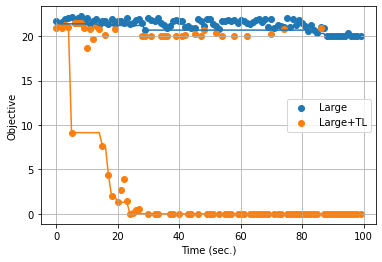

In [16]:
plt.figure()

for strategy, df in results.items():
    if "Large" in strategy:
      x = [i for i in range(len(df))]
      plt.scatter(x, -df.objective, label=strategy)
      plt.plot(x, -df.objective.cummax())

plt.xlabel("Time (sec.)")
plt.ylabel("Objective")
plt.grid()
plt.legend()
plt.show()